# A Simple Implementation of Multiple Linear Regression in Python using numpy from scratch

## Movitation

The following notebook outlines two different ways of implementing multiple linear regression from scratch using only python numpy library.
The main reasons for creating this notebook are to serve as a learning exercise as well as for applications which are limited on space. For certain serverless or edge computing applications which are limited on space, trying to load large libraries like scikit-learn to run saved models is not possible sometimes.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
%matplotlib notebook

### Direct Method 

The below direct solution method for multiple linear regression is implemented as a class similar to sklearn LinearRegression model. The coefficients are calculated using the classic closed form solution (refer Elements of Statistical Learning by Hastie, Tibshirani and Friedman). This method works only if the features are uncorrelated and the matrices are invertible. Also the number of rows should greater than the number of columns in the X features matrix

$$\beta = (X^{T}.X)^{-1}.X^{T}.y$$
The dot represents dot product of matrices.

X feature matrix is of the following form with $m$ rows and $(n+1)$ columns. Here m represents number of training samples and $n$ the number of features, so a $m$ by $n+1$ matrix.

$$X=\begin{bmatrix}
    1 & x_{1,1} & x_{1,2} & ....\\
    1 & x_{2,1} & x_{2,2} & ....\\
    1 & ....                    \\
    . & ....                    \\
    . & ....                    \\
    1 & x_{m,1} & .... & x_{m,n}\\
    \end{bmatrix}$$

The $\beta$ coefficient 1D array is $n+1$ in size with $\beta_0$ representing the intercept,

$$\beta = \begin {bmatrix}
            \beta_{0} \\
            \beta_{1} \\
            .         \\
            .         \\
            .         \\
            \beta_{n} \\
          \end{bmatrix}$$
    
 y is the response 1D array with $m$ training samples.
 $$ y = \begin {bmatrix}
          y_{1} \\
          y_{2} \\
          .     \\
          .     \\
          y_{m} \\
         \end{bmatrix} $$

with the multiple linear regression represented by the following.

$$y=\beta^{T}X^{T}$$

In [3]:
class lin_reg_direct:
    def __init__(self):
        self.X=0.0
        self.y=0.0
    def fit(self,X,y):
        self.y = y
        self.X = np.insert(X,0,1,axis=1)
        self.m = (self.X).shape[0]
        self.n = (self.X).shape[1]
        X_trans = np.transpose(self.X)
        self.beta = np.dot(np.dot(np.linalg.inv(np.dot(X_trans,self.X)),X_trans),self.y)
        
    def coefficients(self):
        return self.beta
    
    def predict(self,X_new):
        X_new = np.insert(X_new,0,1,axis=1)
        self.y_pred = np.transpose(np.dot(np.transpose(self.beta),np.transpose(X_new)))
        return self.y_pred
    
    def cost(self):
        error = self.y_pred - self.y        
        cost = (1/(2*self.m))*np.dot(np.transpose(error),error)        
        return cost
    
    def mse(self):
        return 2*self.cost()
    
    def r2score(self,X_new,y_new):
        y_pred = self.predict(X_new)
        ss_reg = np.sum(np.power((y_pred - y_new),2))
        ss_total = np.sum(np.power(y_pred - np.mean(y_new),2))
        self.R2 = 1-(ss_reg/ss_total)
        m = X_new.shape[0]
        n = X_new.shape[1]
        self.Adj_r2 = 1-(1-self.R2)*(m-1)/(m-n-1)
        return self.R2,self.Adj_r2

### Using Gradient descent 

Gradient descent is a popular numerical method used in machine learning and optimization which is based on Newton's method for solving/minimizing functions. In the case of multiple linear regression a cost function defined which acts as the objective function of the gradient descent minimization problem. The cost function is given as follows

$$ C(\beta) = \frac{1}{2m}\sum_{i=1}^{m}(\beta^{T}x^{i}-y^{i})^2 $$

The summation is over all the training samples. The $\beta$'s are the unknowns in the above relationship and their values which minimizes the cost function represents the best fit hyperplane. The algorithm for finding $\beta$'s is as follows,

$$ $$

$$\beta_{new} = \beta_{old} - \left(\frac{\alpha}{m}\right)(\beta_{old}^{T}.X^{T}-y).X $$

with $\beta$, $X$ and $y$ as defined previously. $\alpha$ represents the learning rate and is a hyperparameter which needs to be adjusted to converge the minimization problem.The above products represents dot products of matrices. The above calculation is repeated $k$ times (epochs). $k$ is another hyperparameter which can be adjusted. The optimization problem in this particular case as a global minimum (convex) and by plotting the cost function with the epochs, the convergence rate can be monitored.

It was found through trial and error that the gradient descent for multiple linear regression works well only when the features are scaled. In this particular implementation I used MinMaxScaler from scikit-learn machine learning package.

In [4]:
class lin_reg_gd:
    def __init__(self):
        self.X=0.0
        self.y=0.0
    def fit(self,X,y,alpha=1e-3,epoch=100):
        self.scaler = MinMaxScaler().fit(X)
        X_scaled = self.scaler.transform(X)
        self.X = np.insert(X_scaled,0,1,axis=1)
        self.y = y
        m = (self.X).shape[0]
        n = (self.X).shape[1]
        self.m = m
        self.n  = n
        theta = np.ones(shape=(n,1))
        theta_t = np.transpose(theta)
        X_t = np.transpose(self.X)
        cost_list = []
        for i in range(0,epoch):
            y_pred = (np.dot(theta_t,X_t))
            error = y_pred - np.transpose(self.y) 
            #error.shape
            cost = 1/(2*m)*np.dot(error,np.transpose(error))
            cost_list.append(cost[0,0])
            #print("Cost = ",cost[0,0])
            theta_t = theta_t - (alpha*np.dot(error,self.X)/m)
        self.coefficients_ = theta_t
        self.cost = cost_list
        self.mse_ = np.dot(error,np.transpose(error))/m
        self.y_pred = np.dot(theta_t,X_t)
        
    def predict(self,X_new):
        X_new = self.scaler.transform(X_new)
        X_new = np.insert(X_new,0,1,axis=1)
        X_t = np.transpose(X_new)
        y_pred = np.transpose(np.dot(self.coefficients_,X_t))
        return y_pred
    
    def r2score(self,X_new,y_new):
        y_pred = (self.predict(X_new)).reshape(-1)
        y_new = y_new.reshape(-1)
        ss_reg = np.sum(np.power((y_pred - (y_new)),2))
        ss_total = np.sum(np.power(y_pred - np.mean(y_new),2))
        self.R2 = 1-(ss_reg/ss_total)
        m = X_new.shape[0]
        n = X_new.shape[1]
        self.Adj_r2 = 1-(1-self.R2)*(m-1)/(m-n-1)
        return self.R2,self.Adj_r2

### Data Input

The following toy dataset is used for validating the algorithms developed in this notebook. The data set is displayed below.The dataset is quite small and it relates the Volume of a tree to Girth, Height and other derived variables.

In [5]:
df = pd.read_csv("Trees.csv")
df = df.drop(labels=['Unnamed: 0'],axis=1)
df.head(10)

,Volume,Girth,Height,GirthHeight,Girth2,Girth2Height
0,10.3,8.3,70,581.0,68.89,4822.30
1,10.3,8.6,65,559.0,73.96,4807.40
2,10.2,8.8,63,554.4,77.44,4878.72
3,16.4,10.5,72,756.0,110.25,7938.00
4,18.8,10.7,81,866.7,114.49,9273.69
5,19.7,10.8,83,896.4,116.64,9681.12
6,15.6,11.0,66,726.0,121.00,7986.00
7,18.2,11.0,75,825.0,121.00,9075.00
8,22.6,11.1,80,888.0,123.21,9856.80
9,19.9,11.2,75,840.0,125.44,9408.00


### Convertion of pandas dataframe into numpy arrays
The dataframe is converted into numpy arrays as all of the algorithms in this study use numpy arrays.

In [6]:
df_X = df.drop(labels=['Volume'],axis=1)
df_Y = df['Volume']
X = df_X.to_numpy()
y = df_Y.to_numpy()
y = y.reshape(-1,1)
n = X.shape[1]

### Scaling using MinMaxScaler

In [7]:
scale1 = MinMaxScaler()
scale1.fit(X)
X_scaled = scale1.transform(X)

### Direct Method

In [8]:
lin_model1 = lin_reg_direct()
lin_model1.fit(X_scaled,y)

In [9]:
print("Coefficients:\n",lin_model1.coefficients())

Coefficients:
 [[  11.90126066]
 [-101.20661675]
 [ -14.78765993]
 [ 127.58632242]
 [ 110.60809981]
 [ -56.65747251]]


In [10]:
y_pred = lin_model1.predict(X_scaled)

In [11]:
df['y_pred1'] = y_pred

In [12]:
print("Cost = ",round(lin_model1.cost()[0,0],3))
print("Mean Squared Error = ",round(lin_model1.mse()[0,0],3))

Cost =  2.851
Mean Squared Error =  5.701


$R^2$ which is the ratio of Explained Variance to Total Variance is displayed below. R-Squared represents what amount of variance (from the mean) seen in the data is explained by the model. A higher R-Squared Value usually means the model is doing a good job of capturing the variance seen in the data. R-Squared can be calculated using the following expression (source Wkipedia - Coefficient of determination)
Residual Sum of Squares
$$ SS_{res} =\sum_{i=1}^{m} (y^{i}-y)^2 $$
Total Sum of Squares
$$ SS_{total} = \sum_{i=1}^{m}(y^{i}-\bar{y})^2$$

R-squared 
$$R^2 = 1-\frac {SS_{res}}{SS_{total}}$$

In multiple regression problems, $R^2$ is weakly positivily correlated with the number of features, meaning as the number of features increase $R^2$ also increases. So $R^2$ is not a robust metric to to compare two different multiple regression models. A modified metric called the Adjusted $R^2$ which penalizes the metric for the number of features can be defined and used. Adjusted $R^2$ is defined as follows

$$Adj-R^2 = 1-(1-R^2)\frac{m-1}{m-n-1}$$

$m$ is the number of training samples and $n$ the number of features. Both the values are displayed below for the current dataset

In [13]:
r2,adj_r2 = lin_model1.r2score(X_scaled,y)
print("R-squared =",np.round(r2,3))
print('Adjusted-R-squared =',np.round(adj_r2,3))

R-squared = 0.978
Adjusted-R-squared = 0.973


### Gradient Descent

In [14]:
lin_modelg1 = lin_reg_gd()
lin_modelg1.fit(X,y,alpha=1.0,epoch=1000)

In [15]:
print("Coefficients = ",lin_modelg1.coefficients_)

Coefficients =  [[ 8.33468619 -3.52045331  1.6461283  12.13512809 22.96633248 34.75604776]]


In [16]:
y_pred2 = lin_modelg1.predict(X)

In [17]:
df['y_pred_gd']=y_pred2

<IPython.core.display.Javascript object>


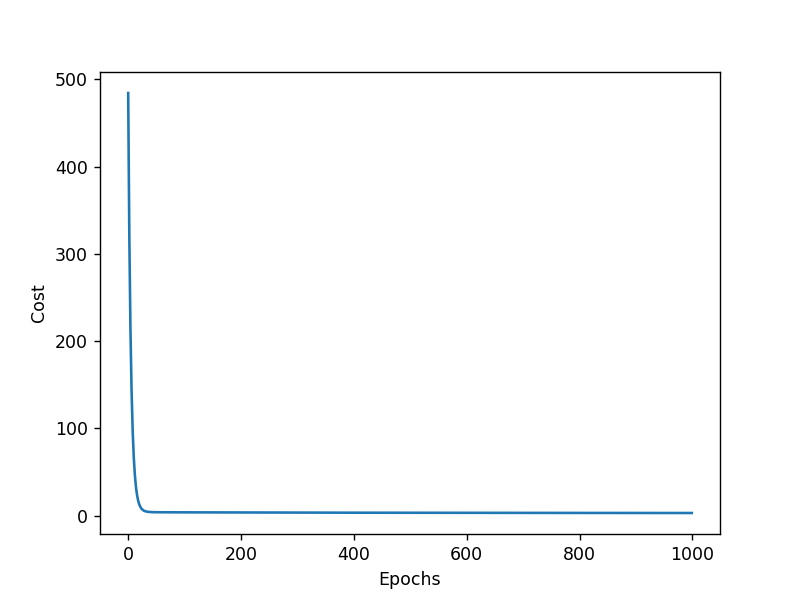

In [18]:
plt.figure()
plt.plot(lin_modelg1.cost)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [ ]:
print("Cost = ",round(lin_modelg1.cost[-1],3))
print("Mean squared Error = ",round(lin_modelg1.mse_[0,0],3))
r2,adj_r2 = lin_modelg1.r2score(X,y)
print("R-squared =",np.round(r2,3))
print("Adjusted R-squared =",np.round(adj_r2,3))

### Scikit Learn Linear Regression model

In [19]:
lin_model_skl = LinearRegression()

In [20]:
lin_model_skl.fit(X_scaled,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
sk_coeff = np.array(lin_model_skl.intercept_)
sk_coeff = np.append(sk_coeff,lin_model_skl.coef_)
print("Coefficients Scikit Learn:\n",sk_coeff)

Coefficients Scikit Learn:
 [  11.90126066 -101.20661675  -14.78765993  127.58632242  110.60809981
  -56.6574725 ]


In [22]:
y_pred2 = lin_model_skl.predict(X_scaled)

In [23]:
df['y_pred_sklearn']=y_pred2

Scikit Learn doesn't seem to have Adjusted R-Squared calculation

In [24]:
print("R-squared score =",round(lin_model_skl.score(X_scaled,y),3))

R-squared score = 0.978


### Comparison of the 3 Models

The coefficients of the 3 models are compared in the below table. Direct Method and Scikit Learn Linear model give the exact same results. Gradient descent gives different set of coefficients. This could be because of the convergence of the solution and the particular learning rate used. It is not clear at this point what causes this discrepancy.

In [25]:
df_coeff = pd.DataFrame()
df_coeff['beta']=np.arange(0,n+1,1)
df_coeff['Direct Method'] = lin_model1.coefficients()
df_coeff['Gradient Descent'] = np.transpose(lin_modelg1.coefficients_)
df_coeff['Sklearn Linear Model']=sk_coeff
df_coeff

,beta,Direct Method,Gradient Descent,Sklearn Linear Model
0,0,11.901261,8.334686,11.901261
1,1,-101.206617,-3.520453,-101.206617
2,2,-14.787660,1.646128,-14.787660
3,3,127.586322,12.135128,127.586322
4,4,110.608100,22.966332,110.608100
5,5,-56.657473,34.756048,-56.657473


The tree Volume predicted by the 3 methods are compared below. Although the linear model coefficients predicted by gradient descent is different from other models, the predicted y are almost exactly the same. 

<IPython.core.display.Javascript object>


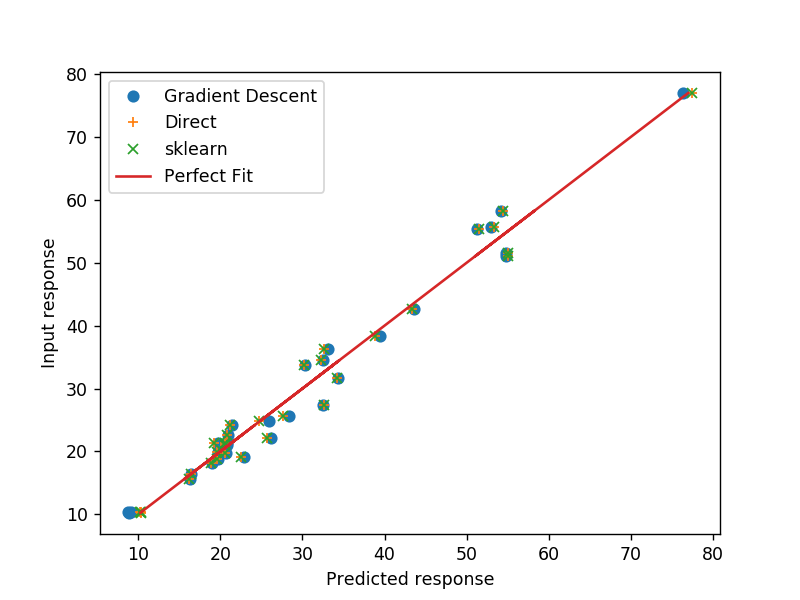

In [26]:
plt.figure()
plt.plot(df['y_pred_gd'],df['Volume'],'o',label="Gradient Descent")
plt.plot(df['y_pred1'],df['Volume'],'+',label="Direct")
plt.plot(df['y_pred_sklearn'],df['Volume'],'x',label='sklearn')
plt.plot(df['Volume'],df['Volume'],label="Perfect Fit")
plt.xlabel("Predicted response")
plt.ylabel('Input response')
plt.legend()
plt.show()

## Boston dataset

Scikit-learn library has many in-built datasets and boston dataset is one of them. The performance of both the implementations are tested on the Boston dataset. More information about the dataset can be learned from the sklearn libraris and also looking at description which is part of the dataset object. The dataset has the following features 
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        
and  MEDV - Median value of owner-occupied homes in $1000's is the response variable.

In [27]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
boston = load_boston()

Splitting the dataset randomly into train and test sets. A cross validation procedure should be used here, but the purpose here is to validate the two implementations on a real dataset.

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

Scaling the dataset using MinMaxScaler. Note this step is not required for either the Direct implementation or sklearn model. The gradient descent implementation requires scaling.

In [29]:
scaler2 = MinMaxScaler()
scaler2.fit(X_train)
X_train_scaled = scaler2.transform(X_train)

The test set is scaled based on the training set to prevent data leakage.

In [30]:
X_test_scaled = scaler2.transform(X_test)

## Comparison of the different model implementations

### Direct Method

In [31]:
lin_model_direct = lin_reg_direct()
lin_model_direct.fit(X_train_scaled,y_train)

In [32]:
print("Coefficients:\n",lin_model_direct.coefficients())

Coefficients:
 [ 27.49272791 -10.47489456   4.40174969  -0.15735494   2.39341594
  -7.57645867  19.67024242  -0.68311581 -15.71607313   5.52186497
  -5.91977522  -9.26413928   3.34889385 -17.59386711]


In [33]:
y_pred_direct = lin_model_direct.predict(X_test_scaled)

In [34]:
r2,adj_r2 = lin_model_direct.r2score(X_test_scaled,y_test)
print("R-squared =",np.round(r2,3))
print("Adjusted R-squared =",np.round(adj_r2,3))

R-squared = 0.499
Adjusted R-squared = 0.441


### Scikit Learn Model

In [35]:
lin_model_sklearn = LinearRegression()
lin_model_sklearn.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
sk_coeff = np.array(lin_model_sklearn.intercept_)
sk_coeff = np.append(sk_coeff,lin_model_sklearn.coef_)
print("Coefficients Scikit Learn:\n",sk_coeff)

Coefficients Scikit Learn:
 [ 27.49272791 -10.47489456   4.40174969  -0.15735494   2.39341594
  -7.57645867  19.67024242  -0.68311581 -15.71607313   5.52186497
  -5.91977522  -9.26413928   3.34889385 -17.59386711]


In [37]:
y_pred_sklearn = lin_model_sklearn.predict(X_test_scaled)

In [38]:
print("R-squared =",round(lin_model_sklearn.score(X_test_scaled,y_test),3))

R-squared = 0.635


### Gradient Descent

In [39]:
lin_model_grad = lin_reg_gd()

In [40]:
lin_model_grad.fit(X_train,y_train,alpha=0.5,epoch=1000)

In [41]:
print('Coefficients Gradient Descent:\n',lin_model_grad.coefficients_)

Coefficients Gradient Descent:
 [[ 25.3151347   -9.25072272   4.03420944   0.03421      2.41617906
   -6.83131341  21.28343716  -0.61315764 -14.16955636   5.04808819
   -5.68808778  -9.05267386   3.70840103 -17.00204124]]


<IPython.core.display.Javascript object>


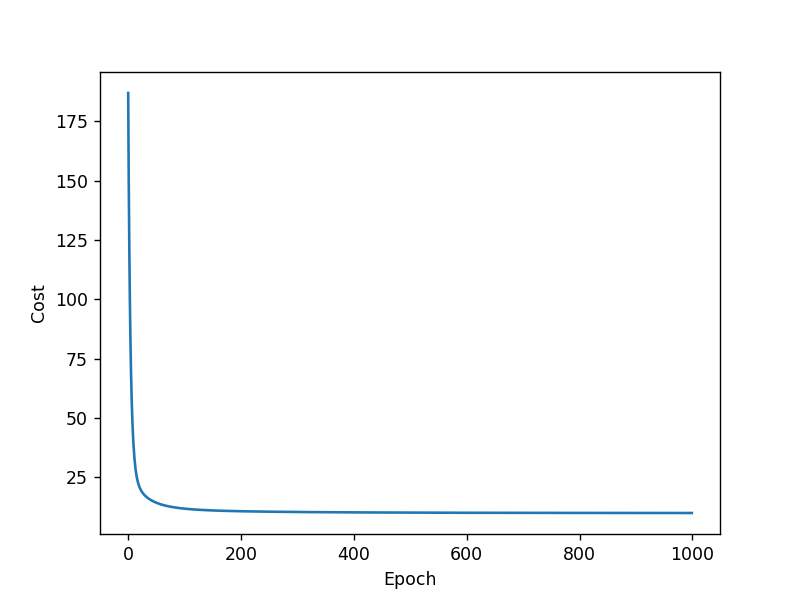

Text(0, 0.5, 'Cost')

In [42]:
plt.figure()
plt.plot(lin_model_grad.cost)
plt.xlabel("Epoch")
plt.ylabel("Cost")

In [44]:
y_pred_gd = lin_model_grad.predict(X_test)
r2,adj_r2 = lin_model_grad.r2score(X_test,y_test)
print("R-squared =",np.round(r2,3))
print("Adjusted R-squared =",np.round(adj_r2,3))

R-squared = 0.501
Adjusted R-squared = 0.443


Again all the 3 methods produce the same results validating the implementation of multiple linear regression. The coefficeints of the linear model are very close to each other. One point to note is the R-squared value is different from what the sklearn model predicts. This could be due to multiple reasons. Not clear on the implementation of R-squared in scikit learn package.

In [52]:
df_coeff = pd.DataFrame()
df_coeff['beta']=np.arange(0,X_train.shape[1]+1,1)
df_coeff['Direct Method'] = lin_model_direct.coefficients()
df_coeff['Gradient Descent'] = lin_model_grad.coefficients_.reshape(-1)
df_coeff['Sklearn Linear Model']=sk_coeff
df_coeff

,beta,Direct Method,Gradient Descent,Sklearn Linear Model
0,0,27.492728,25.315135,27.492728
1,1,-10.474895,-9.250723,-10.474895
2,2,4.401750,4.034209,4.401750
3,3,-0.157355,0.034210,-0.157355
4,4,2.393416,2.416179,2.393416
5,5,-7.576459,-6.831313,-7.576459
6,6,19.670242,21.283437,19.670242
7,7,-0.683116,-0.613158,-0.683116
8,8,-15.716073,-14.169556,-15.716073
9,9,5.521865,5.048088,5.521865


<IPython.core.display.Javascript object>


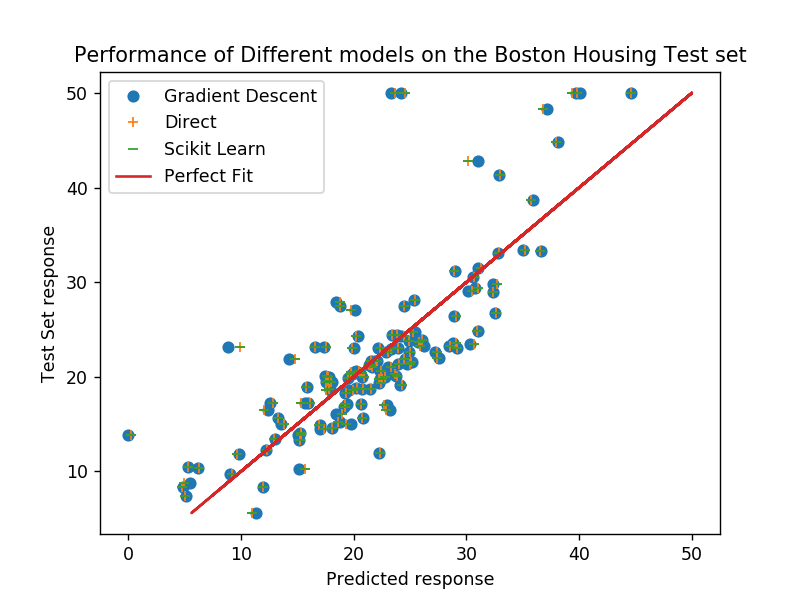

In [53]:
plt.figure()
plt.plot(y_pred_gd,y_test,'o',label='Gradient Descent')
plt.plot(y_pred_direct,y_test,'+',label='Direct')
plt.plot(y_pred_sklearn,y_test,'_',label='Scikit Learn')
plt.plot(y_test,y_test,label='Perfect Fit')
plt.title('Performance of Different models on the Boston Housing Test set')
plt.xlabel("Predicted response")
plt.ylabel('Test Set response')
plt.legend()
plt.show()